<a href="https://colab.research.google.com/github/DrVenkataRajeshKumar/S10/blob/master/S10assignmentfinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [146]:
!git clone https://github.com/DrVenkataRajeshKumar/EVA4Library.git
import sys
sys.path.append("/content/EVA4_LIBRARY/EVA4")

fatal: destination path 'EVA4Library' already exists and is not an empty directory.


In [147]:
!pip install -U git+https://github.com/albu/albumentations > /dev/null && echo "All libraries are successfully installed!"

  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-f_riq9i8
All libraries are successfully installed!


In [148]:
from torchvision import datasets
train = datasets.CIFAR10('./data', train=True, download=True)

Files already downloaded and verified


In [149]:
from tqdm import tqdm_notebook
from PIL import Image
import numpy as np
n = 0
s = np.zeros(3)
sq = np.zeros(3)
for data, l in tqdm_notebook(train):
  x = np.array(data)/255
  s += x.sum(axis=(0,1))
  sq += np.sum(np.square(x), axis=(0,1))
  n += x.shape[0]*x.shape[1]

mu = s/n
std = np.sqrt((sq/n - np.square(mu)))
print(mu, sq/n, std, n)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys



[0.49139968 0.48215841 0.44653091] [0.30249857 0.29176174 0.26781806] [0.24703223 0.24348513 0.26158784] 51200000


In [0]:
# add path to our library in default search path
import sys
sys.path.append('/content/drive/My Drive/EVA4')

In [0]:

import numpy as np
#import eva4datatransforms as eva4datatransforms
from torchvision import transforms
from eva4albumentations import Albumentations
channel_means = (0.49139968, 0.48215841, 0.44653091)
channel_stdevs = (0.24703223, 0.24348513, 0.26158784)
norm_mean_std=[channel_means,channel_stdevs]
# Train Phase transformations
train_transforms = Albumentations(norm_mean_std,Rotate=(-30,30),HorizontalFlip=True,RGBshift=(50,50,50),cutout=(3,))

# Test Phase transformations
test_transforms = Albumentations(norm_mean_std)

In [152]:
from torchvision import datasets
train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
import eva4dataloaders

dataloader = eva4dataloaders.DataLoader(batch_size=128)

# train dataloader
train_loader = dataloader.load(train)

# test dataloader
test_loader = dataloader.load(test)

torch.Size([128, 3, 32, 32])
torch.Size([128])


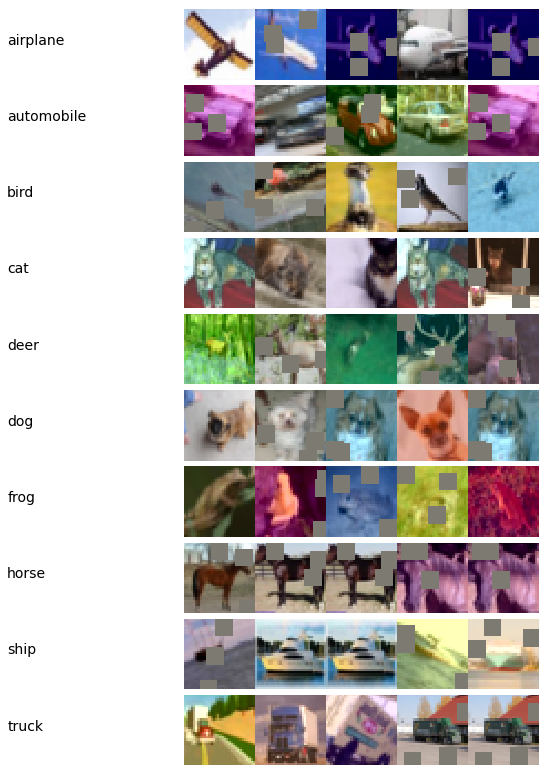

In [154]:
from __future__ import print_function
def unnormalize(img):
  img = img.cpu().numpy().astype(dtype=np.float32)
  
  for i in range(img.shape[0]):
    img[i] = (img[i]*channel_stdevs[i])+channel_means[i]
  
  return np.transpose(img, (1,2,0))

%matplotlib inline
import matplotlib.pyplot as plt
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

num_classes = 10
# display 10 images from each category. 
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
r, c = 10, 11
n = 5
fig = plt.figure(figsize=(14,14))
fig.subplots_adjust(hspace=0.01, wspace=0.01)
for i in range(num_classes):
    idx = np.random.choice(np.where(labels[:]==i)[0], n)
    ax = plt.subplot(r, c, i*c+1)
    ax.text(-1.5, 0.5, class_names[i], fontsize=14)
    plt.axis('off')
    for j in range(1, n+1):
      plt.subplot(r, c, i*c+j+1)
      plt.imshow(unnormalize(images[idx[j-1]]), interpolation='none')
      plt.axis('off')
plt.show()

In [155]:
import rn
import torch
model = rn.ResNet18()
use_cuda = torch.cuda.is_available()
model.device = torch.device("cuda" if use_cuda else "cpu")
model.to(model.device)
model.summary((3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


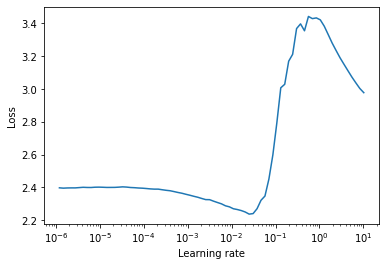

In [156]:
# LR finder fast ai approach
from lrfinder import LRFinder
import torch.optim as optim
import torch.nn as nn
L1lambda = 0
L2lambda = 1e-4
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-7, momentum=0.9, nesterov=True, weight_decay=L2lambda)
lr_finder = LRFinder(model, optimizer, criterion, device=model.device)
lr_finder.range_test(train_loader, end_lr=100, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [0]:
loss = lr_finder.history['loss']
lr = lr_finder.history['lr']
#lr[loss.index(min(loss))]
optimizer = optim.SGD(model.parameters(), lr=lr[loss.index(min(loss))], momentum=0.9, nesterov=True, weight_decay=L2lambda)

In [158]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
EPOCHS = 50
#scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
#scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.5, steps_per_epoch=len(train_loader), epochs=EPOCHS)

scheduler = ReduceLROnPlateau(optimizer, min_lr=1e-7, mode='max', factor=0.95, patience=1, verbose=True)

model.gotrain(optimizer, train_loader, test_loader, EPOCHS, "/content/drive/My Drive", scheduler, False, L1lambda)


Validation loss decreased (100000.000000 --> 1.178448).  Saving model ...
Epoch: 1, Train set: Average loss: 0.0117, Accuracy: 46.18%; Test set: Average loss: 1.1784, Accuracy: 60.18%
Learning Rate = 0.025119



Validation loss decreased (1.178448 --> 1.055563).  Saving model ...
Epoch: 2, Train set: Average loss: 0.0080, Accuracy: 64.07%; Test set: Average loss: 1.0556, Accuracy: 65.28%
Learning Rate = 0.025119



Epoch     3: reducing learning rate of group 0 to 2.3863e-02.
Validation loss decreased (1.055563 --> 0.722198).  Saving model ...
Epoch: 3, Train set: Average loss: 0.0066, Accuracy: 70.55%; Test set: Average loss: 0.7222, Accuracy: 74.85%
Learning Rate = 0.023863



Epoch: 4, Train set: Average loss: 0.0057, Accuracy: 74.34%; Test set: Average loss: 0.8409, Accuracy: 73.63%
Learning Rate = 0.023863



Epoch     5: reducing learning rate of group 0 to 2.2670e-02.
Validation loss decreased (0.722198 --> 0.640376).  Saving model ...
Epoch: 5, Train set: Average loss: 0.0051, Accuracy: 77.19%; Test set: Average loss: 0.6404, Accuracy: 78.64%
Learning Rate = 0.022670



Validation loss decreased (0.640376 --> 0.592020).  Saving model ...
Epoch: 6, Train set: Average loss: 0.0047, Accuracy: 79.28%; Test set: Average loss: 0.5920, Accuracy: 80.40%
Learning Rate = 0.022670



Epoch     7: reducing learning rate of group 0 to 2.1536e-02.
Validation loss decreased (0.592020 --> 0.507477).  Saving model ...
Epoch: 7, Train set: Average loss: 0.0043, Accuracy: 80.94%; Test set: Average loss: 0.5075, Accuracy: 82.98%
Learning Rate = 0.021536



Validation loss decreased (0.507477 --> 0.454273).  Saving model ...
Epoch: 8, Train set: Average loss: 0.0039, Accuracy: 82.53%; Test set: Average loss: 0.4543, Accuracy: 84.18%
Learning Rate = 0.021536



Epoch     9: reducing learning rate of group 0 to 2.0459e-02.
Epoch: 9, Train set: Average loss: 0.0037, Accuracy: 83.82%; Test set: Average loss: 0.5187, Accuracy: 82.91%
Learning Rate = 0.020459



Validation loss decreased (0.454273 --> 0.442524).  Saving model ...
Epoch: 10, Train set: Average loss: 0.0034, Accuracy: 84.64%; Test set: Average loss: 0.4425, Accuracy: 85.50%
Learning Rate = 0.020459



Epoch    11: reducing learning rate of group 0 to 1.9436e-02.
Validation loss decreased (0.442524 --> 0.421367).  Saving model ...
Epoch: 11, Train set: Average loss: 0.0032, Accuracy: 85.86%; Test set: Average loss: 0.4214, Accuracy: 86.27%
Learning Rate = 0.019436



Validation loss decreased (0.421367 --> 0.405919).  Saving model ...
Epoch: 12, Train set: Average loss: 0.0030, Accuracy: 86.73%; Test set: Average loss: 0.4059, Accuracy: 87.00%
Learning Rate = 0.019436



Epoch    13: reducing learning rate of group 0 to 1.8465e-02.
Epoch: 13, Train set: Average loss: 0.0029, Accuracy: 87.28%; Test set: Average loss: 0.4142, Accuracy: 86.33%
Learning Rate = 0.018465



Validation loss decreased (0.405919 --> 0.388374).  Saving model ...
Epoch: 14, Train set: Average loss: 0.0027, Accuracy: 88.34%; Test set: Average loss: 0.3884, Accuracy: 87.51%
Learning Rate = 0.018465



Epoch    15: reducing learning rate of group 0 to 1.7541e-02.
Validation loss decreased (0.388374 --> 0.382935).  Saving model ...
Epoch: 15, Train set: Average loss: 0.0026, Accuracy: 88.66%; Test set: Average loss: 0.3829, Accuracy: 87.36%
Learning Rate = 0.017541



Epoch: 16, Train set: Average loss: 0.0024, Accuracy: 89.31%; Test set: Average loss: 0.4524, Accuracy: 85.61%
Learning Rate = 0.017541



Epoch    17: reducing learning rate of group 0 to 1.6664e-02.
Validation loss decreased (0.382935 --> 0.363422).  Saving model ...
Epoch: 17, Train set: Average loss: 0.0023, Accuracy: 89.75%; Test set: Average loss: 0.3634, Accuracy: 88.44%
Learning Rate = 0.016664



Validation loss decreased (0.363422 --> 0.353358).  Saving model ...
Epoch: 18, Train set: Average loss: 0.0022, Accuracy: 90.06%; Test set: Average loss: 0.3534, Accuracy: 88.63%
Learning Rate = 0.016664



Epoch    19: reducing learning rate of group 0 to 1.5831e-02.
Epoch: 19, Train set: Average loss: 0.0021, Accuracy: 90.76%; Test set: Average loss: 0.3643, Accuracy: 88.10%
Learning Rate = 0.015831



Epoch: 20, Train set: Average loss: 0.0020, Accuracy: 91.14%; Test set: Average loss: 0.3577, Accuracy: 88.93%
Learning Rate = 0.015831



Epoch    21: reducing learning rate of group 0 to 1.5040e-02.
Validation loss decreased (0.353358 --> 0.351664).  Saving model ...
Epoch: 21, Train set: Average loss: 0.0019, Accuracy: 91.69%; Test set: Average loss: 0.3517, Accuracy: 89.39%
Learning Rate = 0.015040



Epoch: 22, Train set: Average loss: 0.0018, Accuracy: 91.90%; Test set: Average loss: 0.3661, Accuracy: 89.02%
Learning Rate = 0.015040



Epoch    23: reducing learning rate of group 0 to 1.4288e-02.
Epoch: 23, Train set: Average loss: 0.0017, Accuracy: 92.41%; Test set: Average loss: 0.3582, Accuracy: 89.07%
Learning Rate = 0.014288



Epoch: 24, Train set: Average loss: 0.0016, Accuracy: 92.75%; Test set: Average loss: 0.3726, Accuracy: 88.96%
Learning Rate = 0.014288



Epoch    25: reducing learning rate of group 0 to 1.3573e-02.
Validation loss decreased (0.351664 --> 0.335763).  Saving model ...
Epoch: 25, Train set: Average loss: 0.0016, Accuracy: 92.95%; Test set: Average loss: 0.3358, Accuracy: 89.77%
Learning Rate = 0.013573



Validation loss decreased (0.335763 --> 0.328072).  Saving model ...
Epoch: 26, Train set: Average loss: 0.0015, Accuracy: 93.19%; Test set: Average loss: 0.3281, Accuracy: 89.85%
Learning Rate = 0.013573



Epoch    27: reducing learning rate of group 0 to 1.2895e-02.
Validation loss decreased (0.328072 --> 0.315367).  Saving model ...
Epoch: 27, Train set: Average loss: 0.0015, Accuracy: 93.51%; Test set: Average loss: 0.3154, Accuracy: 90.18%
Learning Rate = 0.012895



Epoch: 28, Train set: Average loss: 0.0014, Accuracy: 93.97%; Test set: Average loss: 0.3331, Accuracy: 90.51%
Learning Rate = 0.012895



Epoch    29: reducing learning rate of group 0 to 1.2250e-02.
Epoch: 29, Train set: Average loss: 0.0014, Accuracy: 93.89%; Test set: Average loss: 0.3463, Accuracy: 90.00%
Learning Rate = 0.012250



Epoch: 30, Train set: Average loss: 0.0013, Accuracy: 94.16%; Test set: Average loss: 0.3324, Accuracy: 90.21%
Learning Rate = 0.012250



Epoch    31: reducing learning rate of group 0 to 1.1637e-02.
Epoch: 31, Train set: Average loss: 0.0013, Accuracy: 94.40%; Test set: Average loss: 0.3178, Accuracy: 90.60%
Learning Rate = 0.011637



Epoch: 32, Train set: Average loss: 0.0012, Accuracy: 94.66%; Test set: Average loss: 0.3636, Accuracy: 89.94%
Learning Rate = 0.011637



Epoch    33: reducing learning rate of group 0 to 1.1055e-02.
Validation loss decreased (0.315367 --> 0.313648).  Saving model ...
Epoch: 33, Train set: Average loss: 0.0012, Accuracy: 94.69%; Test set: Average loss: 0.3136, Accuracy: 90.65%
Learning Rate = 0.011055



Validation loss decreased (0.313648 --> 0.298618).  Saving model ...
Epoch: 34, Train set: Average loss: 0.0011, Accuracy: 94.98%; Test set: Average loss: 0.2986, Accuracy: 91.49%
Learning Rate = 0.011055



Epoch    35: reducing learning rate of group 0 to 1.0503e-02.
Epoch: 35, Train set: Average loss: 0.0011, Accuracy: 95.18%; Test set: Average loss: 0.3236, Accuracy: 90.79%
Learning Rate = 0.010503



Epoch: 36, Train set: Average loss: 0.0011, Accuracy: 95.24%; Test set: Average loss: 0.3415, Accuracy: 90.25%
Learning Rate = 0.010503



Epoch    37: reducing learning rate of group 0 to 9.9776e-03.
Epoch: 37, Train set: Average loss: 0.0010, Accuracy: 95.68%; Test set: Average loss: 0.3175, Accuracy: 90.95%
Learning Rate = 0.009978



Epoch: 38, Train set: Average loss: 0.0010, Accuracy: 95.84%; Test set: Average loss: 0.3294, Accuracy: 90.99%
Learning Rate = 0.009978



Epoch    39: reducing learning rate of group 0 to 9.4787e-03.
Epoch: 39, Train set: Average loss: 0.0009, Accuracy: 95.98%; Test set: Average loss: 0.3089, Accuracy: 91.39%
Learning Rate = 0.009479



Epoch: 40, Train set: Average loss: 0.0010, Accuracy: 95.85%; Test set: Average loss: 0.3180, Accuracy: 91.15%
Learning Rate = 0.009479



Epoch    41: reducing learning rate of group 0 to 9.0048e-03.
Epoch: 41, Train set: Average loss: 0.0009, Accuracy: 96.09%; Test set: Average loss: 0.3284, Accuracy: 90.97%
Learning Rate = 0.009005



Epoch: 42, Train set: Average loss: 0.0009, Accuracy: 96.19%; Test set: Average loss: 0.3019, Accuracy: 91.36%
Learning Rate = 0.009005



Epoch    43: reducing learning rate of group 0 to 8.5545e-03.
Epoch: 43, Train set: Average loss: 0.0009, Accuracy: 96.21%; Test set: Average loss: 0.3274, Accuracy: 91.20%
Learning Rate = 0.008555



Epoch: 44, Train set: Average loss: 0.0008, Accuracy: 96.37%; Test set: Average loss: 0.3084, Accuracy: 91.50%
Learning Rate = 0.008555



Epoch    45: reducing learning rate of group 0 to 8.1268e-03.
Epoch: 45, Train set: Average loss: 0.0008, Accuracy: 96.51%; Test set: Average loss: 0.3105, Accuracy: 91.29%
Learning Rate = 0.008127



Epoch: 46, Train set: Average loss: 0.0008, Accuracy: 96.66%; Test set: Average loss: 0.3141, Accuracy: 91.77%
Learning Rate = 0.008127



Epoch    47: reducing learning rate of group 0 to 7.7205e-03.
Epoch: 47, Train set: Average loss: 0.0008, Accuracy: 96.75%; Test set: Average loss: 0.3050, Accuracy: 91.32%
Learning Rate = 0.007720



Epoch: 48, Train set: Average loss: 0.0007, Accuracy: 96.85%; Test set: Average loss: 0.3054, Accuracy: 91.70%
Learning Rate = 0.007720



Epoch    49: reducing learning rate of group 0 to 7.3344e-03.
Epoch: 49, Train set: Average loss: 0.0007, Accuracy: 96.85%; Test set: Average loss: 0.3032, Accuracy: 91.70%
Learning Rate = 0.007334



Validation loss decreased (0.298618 --> 0.292539).  Saving model ...
Epoch: 50, Train set: Average loss: 0.0007, Accuracy: 97.00%; Test set: Average loss: 0.2925, Accuracy: 91.72%
Learning Rate = 0.007334



In [159]:
print('maximum train accuracy',100*(max(model.stats().train_acc)))
print('maximum test accuracy',100*(max(model.stats().test_acc)))

maximum train accuracy 97.0
maximum test accuracy 91.77


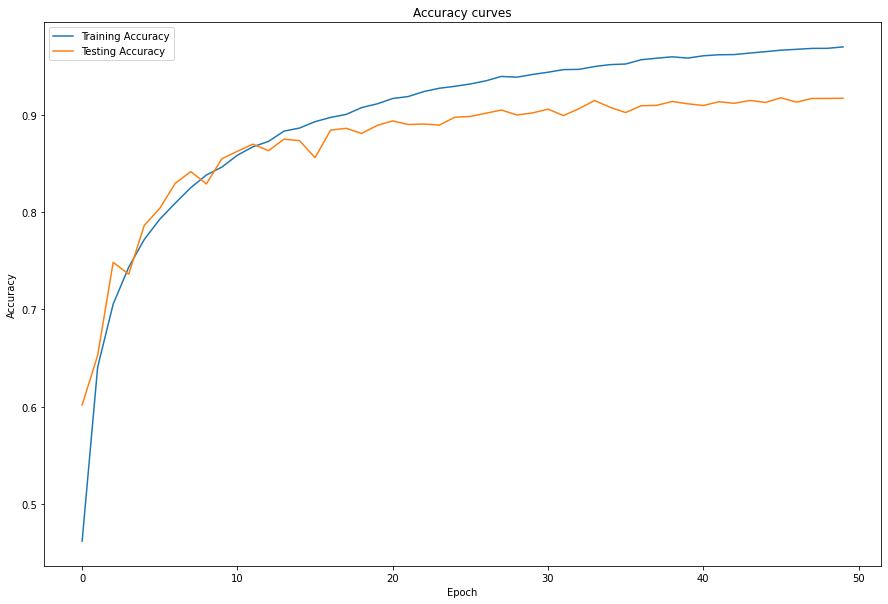

In [160]:
plt.figure(figsize=(15, 10))
ax = plt.subplot(111)
ax.plot(model.stats().train_acc)
ax.plot(model.stats().test_acc)

ax.set(title="Accuracy curves", xlabel="Epoch", ylabel="Accuracy")
ax.legend(['Training Accuracy', 'Testing Accuracy'], loc='best')
plt.savefig("TrainTestAccuracy.png")
plt.show()

In [161]:
len(model.stats().get_misclassified_images())

25

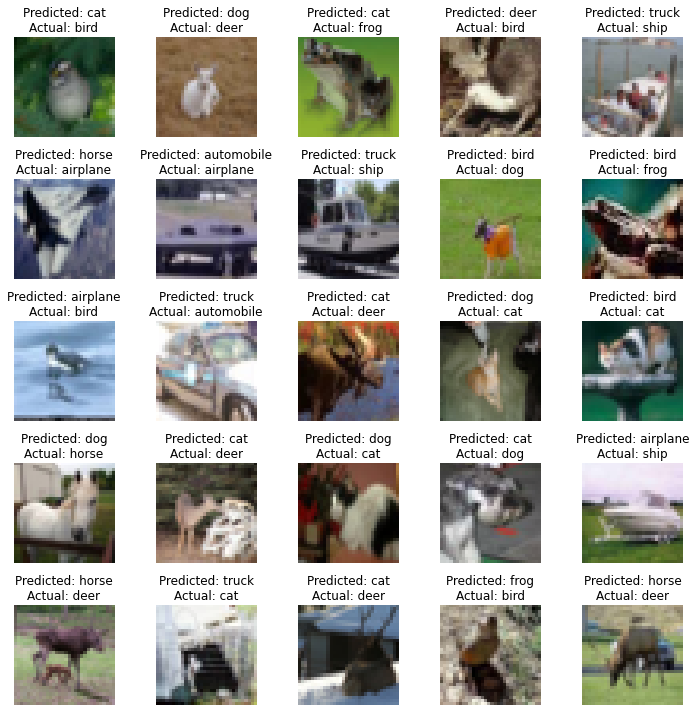

In [162]:
import plots

plots.plot_images(model.stats().get_misclassified_images(), class_names, "misclassified_imgs.png", mean=list(channel_means), std=list(channel_stdevs))

In [0]:
mimages = model.stats().get_misclassified_images()
images = []
target_classes = []
pred_classes = []
for i in mimages:
  images.append(i["img"])
  target_classes.append(int(i['target']))
  pred_classes.append(int(i['pred']))

In [164]:
print(target_classes)
print(pred_classes)

[2, 4, 6, 2, 8, 0, 0, 8, 5, 6, 2, 1, 4, 3, 3, 7, 4, 3, 5, 8, 4, 3, 4, 2, 4]
[3, 5, 3, 4, 9, 7, 1, 9, 2, 2, 0, 9, 3, 5, 2, 5, 3, 5, 3, 0, 7, 9, 3, 6, 7]


In [165]:
model.load_state_dict(torch.load(f"/content/drive/My Drive/{model.name}.pt"))

<All keys matched successfully>

torch.Size([10, 10])
Generating Grad-CAM @layer1
Generating Grad-CAM @layer2
Generating Grad-CAM @layer3
Generating Grad-CAM @layer4


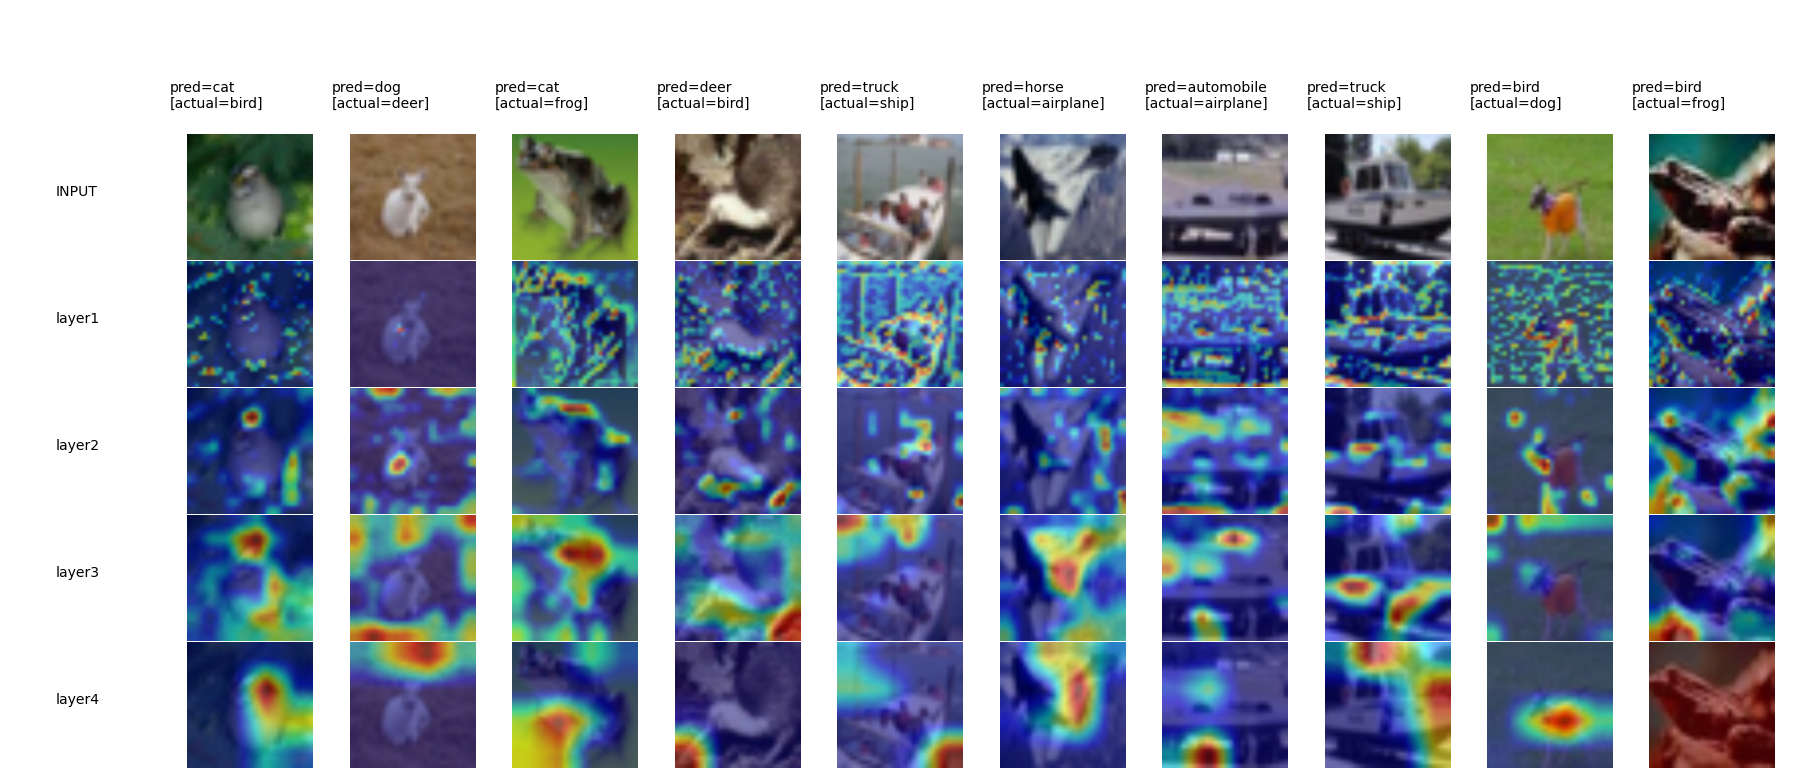

torch.Size([10, 10])
Generating Grad-CAM @layer1
Generating Grad-CAM @layer2
Generating Grad-CAM @layer3
Generating Grad-CAM @layer4


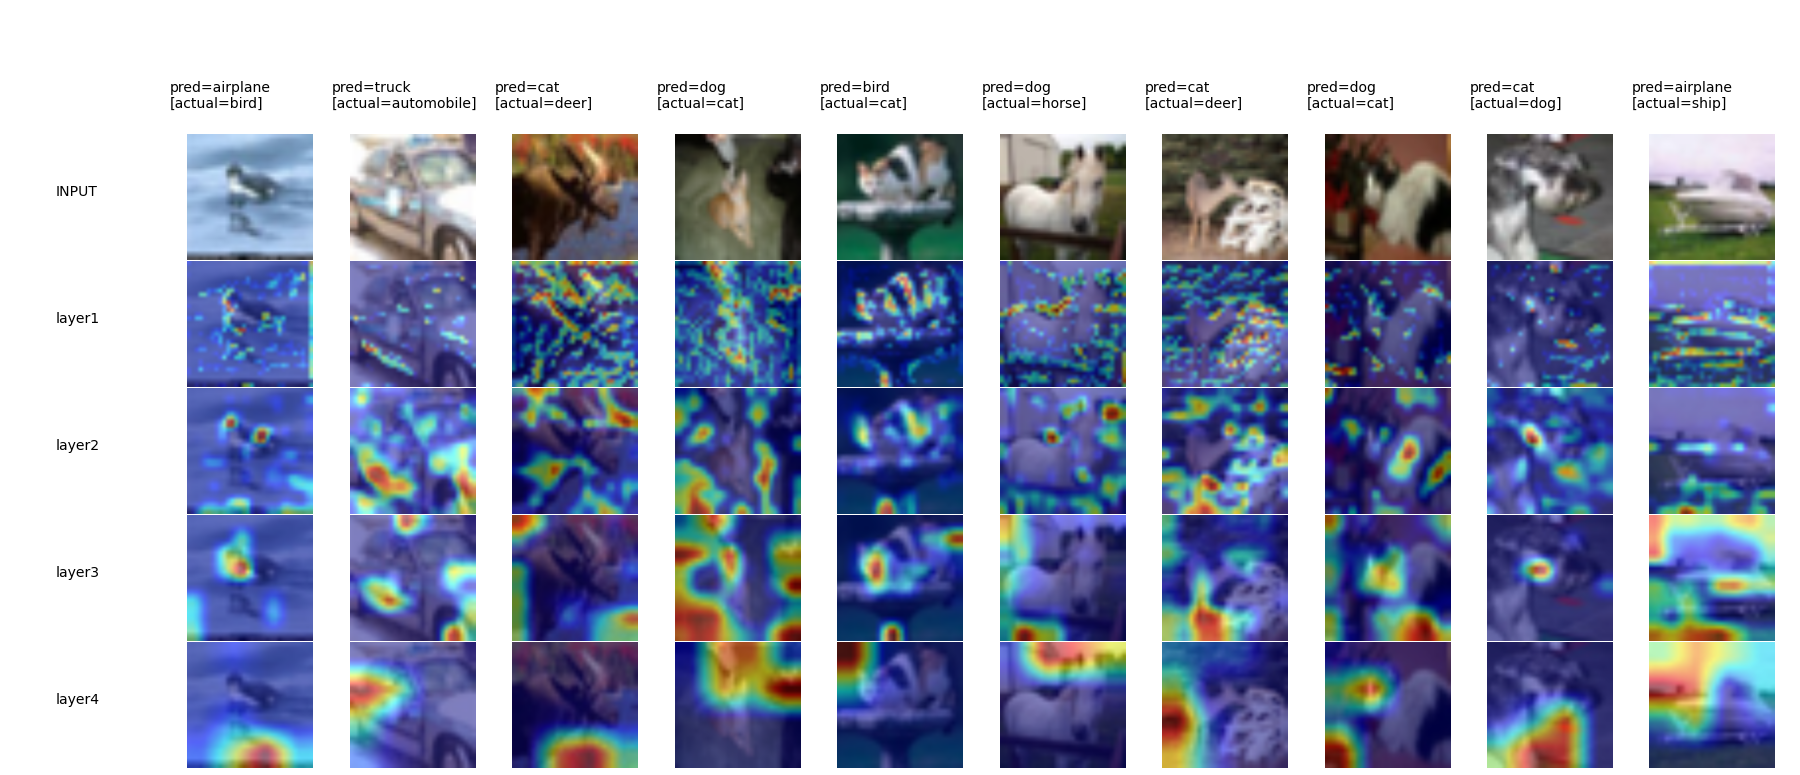

torch.Size([5, 10])
Generating Grad-CAM @layer1
Generating Grad-CAM @layer2
Generating Grad-CAM @layer3
Generating Grad-CAM @layer4


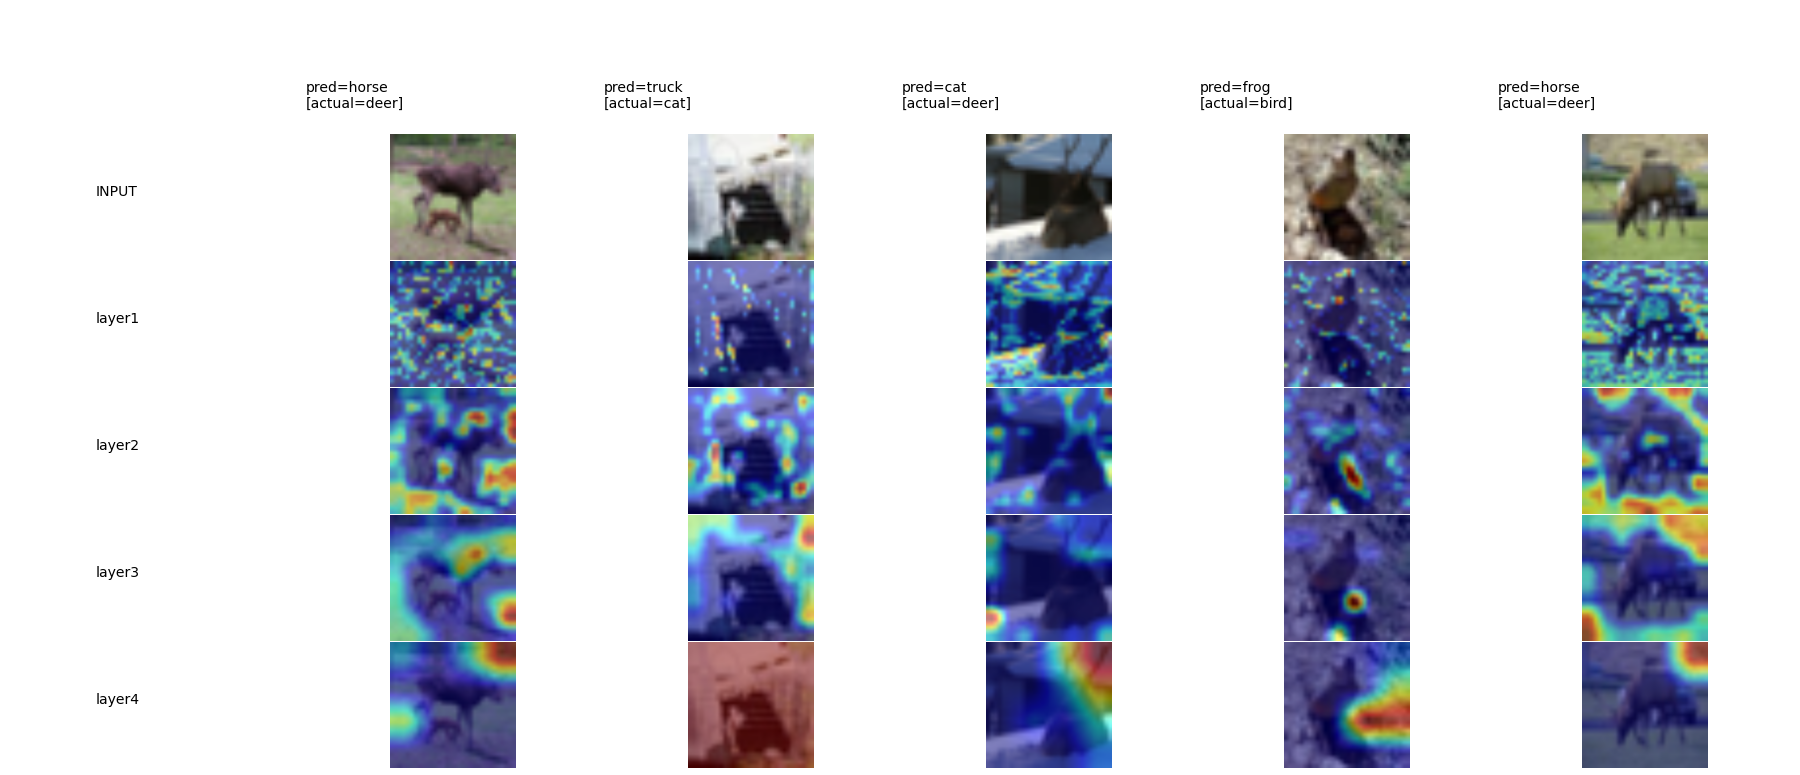

In [166]:
from gradcam import GRADCAM, PLOT
target_layers = ["layer1", "layer2", "layer3", "layer4"]
#Gradcam plot for first 10 misclassified images
gradcam_output, probs, predicted_classes = GRADCAM(images[:10], target_classes[:10], model, target_layers)
PLOT(gradcam_output, images[:10], target_classes[:10], target_layers, class_names, (3, 32, 32), predicted_classes, unnormalize)
#Gradcam plot for 11-20 misclassified images
gradcam_output, probs, predicted_classes = GRADCAM(images[10:20], target_classes[10:20], model, target_layers)
PLOT(gradcam_output, images[10:20], target_classes[10:20], target_layers, class_names, (3, 32, 32), predicted_classes, unnormalize)
#Gradcam plot for 21-25 misclassified images
gradcam_output, probs, predicted_classes = GRADCAM(images[20:], target_classes[20:], model, target_layers)
PLOT(gradcam_output, images[20:], target_classes[20:], target_layers, class_names, (3, 32, 32), predicted_classes, unnormalize)